# Randomized Benchmarking: Additional Tools Tutorial

The main purpose of this tutorial is to demonstrate the key tools in `pygsti` that can be used to perform, and analyze, simulations of RB. It will also demonstrate some minor additonal tools for analyzing RB data. Specifically, this tutorial will show:

- How to simulate RB experiments for a given gateset.
- How to fit RB data to the 'first order' fitting model
- How to plot theory-predicted RB decay curves for a given gateset
- How to compute properties of the gateset that are relevant to RB.

In [1]:
from __future__ import print_function #python 2 & 3 compatibility

import pygsti
from pygsti.extras import rb
from pygsti.construction import std1Q_XYI

%matplotlib inline

Fully specified RPE configuration.


## Generating simulated data
For this tutorial, we will again use $I$, $X(\pi/2)$, $Y(\pi/2)$ as the target set of primitive gates. Moreover, as before, we will consider an experimenal gate set with uniform depolarizing noise on each *primitive* gate (so, the noise will not be uniform on the compiled Cliffords).

In [2]:
gs_target = std1Q_XYI.gs_target
depol_strength = 1e-3
gs_experimental = std1Q_XYI.gs_target
gs_experimental = gs_experimental.depolarize(gate_noise=depol_strength)

As in the previous tutorial, we now specify the simulation parameters. Creating the simulated data can take a non-trivial length of time, depending on the number of sequences sampled etc.

In [3]:
m_min = 1        # minimum Clifford sequence length
m_max = 1000     # maximum Clifford sequence length
delta_m = 50    # length step size 
K_m_sched = 10   # K_m == 10 (constant) for all m
N = 100          # The number of clicks per experiment and simulate our data

clifford_to_primitive = rb.std1Q.clifford_to_XYI
# get the 1Q Clifford group: the canonical set of superoperator matrices representing the Clifford group, used later.
clifford_group = rb.std1Q.clifford_group

We now generator the set of random sequences (see previous tutorial).

In [4]:
filename_base = 'tutorial_files/rb_template'
rb_sequences = rb.write_empty_rb_files(filename_base, m_min, m_max, delta_m,
                                       clifford_group, K_m_sched,
                                       {'primitive': clifford_to_primitive},
                                       seed=0)

all_rb_sequences = [] #construct an aggregate list of Clifford sequences
for seqs_for_single_cliff_len in rb_sequences['clifford']:
    all_rb_sequences.extend(seqs_for_single_cliff_len)

We now generate the simulated RB data.

In the following, aliasDict is used to generate fake data for *Clifford-label* sequences using a GateSet containing primitive gates, and the collisionAction argument properly handles duplicate Clifford strings, as the default behavior aggregates duplicate strings, but this is *not* what we want for RB. RB requires *independently* chosen strings without regard for duplicates.

For this simulation we have set `sampleError` to "none", which means that there is no finite sampling error on each individual sequence, and the value of $N$ that has been specified above is irrelevant. For finite sampling, set to "binomial". 

In [5]:
rb_data = pygsti.construction.generate_fake_data(gs_experimental,all_rb_sequences,N,sampleError="none",seed=1,
                            aliasDict=clifford_to_primitive, collisionAction="keepseparate")

We then perform the RB analysis on this data, and display the output (see previous tutorial).

In [6]:
rb_results = rb.do_randomized_benchmarking(rb_data, all_rb_sequences,success_spamlabel='minus', dim=2)
rb_results.compute_bootstrap_error_bars(seed=0)

Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-param

## First order fitting function 
As in the previous tutorial, we can access the parameters obtained from fitting to the standard fitting mode. $P_m = A+B\,f^m$, and the RB number extracted from these parameters via $r = (1-f)(d-1)/d$, by using the function

In [7]:
rb_results.print_clifford()

RB results

  - Fitting to the standard function: A + B*f^m.
  - Boostrapped-derived error bars (1 sigma).

A = 0.499867070385 +/- 0.00994490371053
B = 0.499941549876 +/- 0.00929469173441
f = 0.996460208633 +/- 0.000194253473652
r = 0.00176989568351 +/- 9.71267368259e-05



However, when implementing `rb.do_randomized_benchmarking`, the RB data has also been fit to the 'first order' fitting function $P_m = A_1+(B_1+C_1m)\,f_1^m$ (with the RB number obtained in this case denoted $r_1$). This is the model introduced in ["Scalable and Robust Benchmarking of Quantum Processes"](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.180504). The obtained fit parameters can be extracted by specifying the optional parameter `fitting` to be "first order", or "all", as shown below. Note however, that it is not clear that fitting to this model, instead of the standard fitting model, is well-motived (see, e.g., arXiv:1702.01853).

In [8]:
rb_results.print_clifford(fitting='all')

RB results

  - Fitting to the standard function: A + B*f^m.
  - Boostrapped-derived error bars (1 sigma).

A = 0.499867070385 +/- 0.00994490371053
B = 0.499941549876 +/- 0.00929469173441
f = 0.996460208633 +/- 0.000194253473652
r = 0.00176989568351 +/- 9.71267368259e-05

RB results 

  - Fitting to the first order fitting function: A1 + (B1+C1m)*f1^m.
  - with boostrapped-derived error bars (1 sigma).

A1 = 0.499867070385 +/- 0.00996201037067
B1 = 0.499941549876 +/- 0.00924013679534
C1 = 0.0 +/- 1.45323440414e-05
f1 = 0.996460208633 +/- 0.000196211275132
r1 = 0.00176989568351 +/- 9.81056375658e-05



## Comparing simulated RB data to RB theory

RB theory relates to properties of the Clifford gateset, and not to properties of the primitive gateset. As such, to derive relevant theory parameters, we need to construct our experimental Clifford gateset from the experimental primitive gateset and the compilation table that we have used in the RB simulations. To calculate certain quantities, we also require the target Clifford gateset, which, for the 1-qubit Cliffords, is defined in pyGSTi. We will also need the Clifford matrix group.

In [9]:
gs_clifford = pygsti.construction.build_alias_gateset(gs_experimental,clifford_to_primitive)
gs_clifford_target = rb.std1Q.gs_clifford_target
clifford_group = rb.std1Q.clifford_group

As shown in the previous tutorial, we can plot the simulated RB data, and the standard fit decay curve using `rb_results.plot()`. Moreover, by giving this function a range of optional parameters we can compare this fit to the fit obtained from the first order model, and to the RB decay curves predicted by various RB theories.

In particular:

- `fitting` : str, "standard" (default), "first order", or "all". This specifies which fit to plot
- `exact_decay` : bool, specifies whether to plot the *exact* RB decay curve, as predicted by the "$R$ matrix" theory given in arXiv:1702.01853.
- `L_matrix_decay` : bool, specifies whether to plot the RB decay curve predicted by the "$L$ matrix" theory given in arXiv:1702.01853. This theory is approximate.
- `L_matrix_decay_SEB` : bool, specifies whether to plot error bounds for the "$L$ matrix" theory. This shows the region around the predicted RB decay within which the exact theory is guaranteed to fall.

All of these are plotted below:

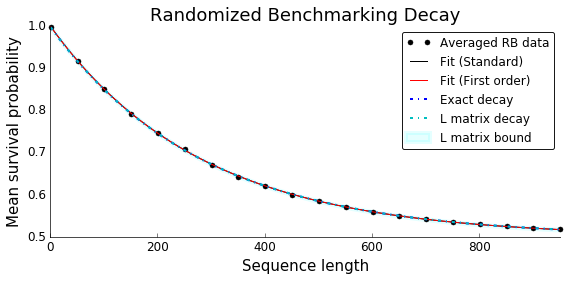

In [10]:
rb_results.plot(fitting='all',exact_decay=True,L_matrix_decay=True,L_matrix_decay_SEB=True, 
                gs=gs_clifford,gs_target=gs_clifford_target,group=clifford_group)

We can also plot the predicted decay curves of the "zeroth order" and "first order" RB theories of Magesan et al., and error bounds which show the region around the predicted decays in which the exact RB surivival probabilities are guaranteed to fall. 

In the following plot, we see that the predictions of the "zeroth order" and "first order" theories are correct, but the error bounds are poor, showing that they are not guaranteed to be good.

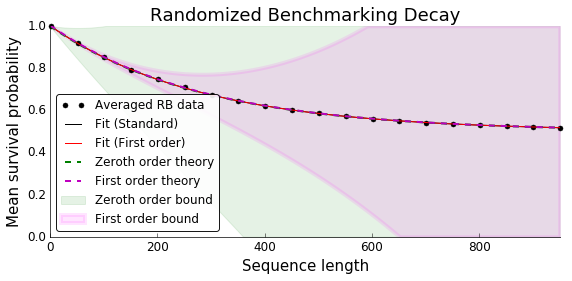

In [11]:
rb_results.plot(fitting='all',Magesan_zeroth=True,Magesan_zeroth_SEB=True,Magesan_first=True,
                Magesan_first_SEB=True,exact_decay=False,L_matrix_decay=False,L_matrix_decay_SEB=False,
                gs=gs_clifford,gs_target=gs_clifford_target,group=clifford_group,loc='lower left')

## Average gateset infidelity and the RB number
From the gateset, we can also calculate a range of quantities that are directly relevant to RB. In particular, we can calculate the mean of the *average gateset infidelity* (AGsI) of the experimental Cliffords to the target Cliffords. This is defined as the average over $i$ of $1-\bar{F}_i$ where
$$ \bar{F}_i: = \int d\psi \,\, \text{Tr} \left(\tilde{C}_i [|\psi \rangle \langle \psi |] C_i[|\psi \rangle \langle \psi | ] \right), $$
with $\tilde{C}_i$ the experimental Cliffords and $C_i$ the target Cliffords. We can also calculate a quantity from both the "$R$ matrix" and the "$L$ matrix" theories: $r_R = (1-e_R)(1-d)/d$ and $r_L = (1-e_L)(1-d)/d$, where $e_R$ and $e_L$ are the second largest eigenvalues of the $R$ and $L$ matrices from arXiv:1702.01853, respectively.

In the RB literature (e.g., see ["Scalable and Robust Benchmarking of Quantum Processes"](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.180504)), it is often claimed that $r$ should correspond to the AGsI (this is provably true in certain cases). In arXiv:1702.01853 it is argued that $r_L \approx r$ for low-error gates, and for similar reason, we should have that $r_R \approx r$ for low error gates.

In [12]:
gateset_metrics = rb.gateset_metrics(gs_clifford,gs_clifford_target,clifford_group,d=2,output=True)
print('The estimate of r is:',rb_results.dicts['clifford']['r'],'+/-',rb_results.dicts['clifford']['r_error_BS'])

The average gateset infidelity is: 0.00176791958146
The scalar error metric obtained from the R matrix is: 0.00176791958146
The scalar error metric obtained from the L matrix is: 0.00176791958146
The estimate of r is: 0.00176989568351 +/- 9.71267368259e-05


In this case we see that all three theory quantities are equal (to machine precision), and they are very close to the simulated estimate of $r$. Note however, that this error model is particularly benign. In future tutorials we will demonstrate that $r$ is not always a good estimate of AGsI, and provide more details on these quantities.